In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT= creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC= creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [18]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import itertools
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, train_loaders, val_loaders, epochs, lr, device, current_threshold, patience=15):
    print(f"\n[INIT] --- MODO DEBUG EXTREMO ATIVADO (CORRIGIDO) ---")
    print(f"[INIT] Device: {device} | LR: {lr} | Threshold: {current_threshold}")

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss() 
    
    metrics = [
        'loss1_a', 'loss1_b', 'loss1_c', 'loss_ex1_avg',
        'loss2_a', 'loss2_b', 'loss2_c', 'loss_ex2_avg',
        'l_joint', 'total_loss'
    ]

    history = {
        'train': {k: [] for k in metrics},
        'val': {k: [] for k in metrics}
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    max_train_batches = max(len(l) for l in train_loaders) 
    train_iter_loaders = [itertools.cycle(l) if len(l) < max_train_batches else l for l in train_loaders]
    
    max_val_batches = max(len(l) for l in val_loaders)
    val_iter_loaders = [itertools.cycle(l) if len(l) < max_val_batches else l for l in val_loaders]

    for epoch in range(epochs):
        print(f"\n{'#'*30} EPOCH {epoch+1}/{epochs} START {'#'*30}")
        model.train()
        
        running_metrics = {k: 0.0 for k in metrics}
        total_steps = 0

        loader_iterators = [iter(l) for l in train_iter_loaders]
                
        for batch_idx in range(max_train_batches):
            print(f"\n>>> [TRAIN] BATCH {batch_idx} START <<<")
            
            try:
                batches = [next(it) for it in loader_iterators]
            except StopIteration:
                print("[DEBUG] StopIteration atingido.")
                break
            
            optimizer.zero_grad()

            (inputs_a, labels_a) = batches[0]
            (inputs_b, labels_b) = batches[1]
            (inputs_c, labels_c) = batches[2]
            
            inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
            inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
            inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
            
            # --- DEBUG DE DADOS DE ENTRADA ---
            print(f"[DATA A] Shape: {inputs_a.shape} | Mean: {inputs_a.mean():.3f} | Std: {inputs_a.std():.3f} | Min: {inputs_a.min():.3f} | Max: {inputs_a.max():.3f}")
            
            # --- FORWARD EXIT 1 ---
            out1_a = model.forward_exit1(inputs_a)
            out1_b = model.forward_exit1(inputs_b)
            out1_c = model.forward_exit1(inputs_c)

            # --- DEBUG LOGITS ---
            print(f"[LOGITS Ex1 A] Mean Abs: {out1_a.abs().mean():.3f} | Max: {out1_a.max():.3f}")

            probs_a = F.softmax(out1_a, dim=1)
            conf_a, _ = torch.max(probs_a, dim=1)

            probs_b = F.softmax(out1_b, dim=1)
            conf_b, _ = torch.max(probs_b, dim=1)

            probs_c = F.softmax(out1_c, dim=1)
            conf_c, _ = torch.max(probs_c, dim=1)
            
            # --- DEBUG PROBABILIDADES DETALHADAS (CORRIGIDO) ---
            # Determina o numero de classes dinamicamente para evitar erro se classes < 3
            num_classes = probs_a.size(1)
            k_val = min(3, num_classes) 
            
            top_k_prob, top_k_idx = torch.topk(probs_a[0], k_val)
            print(f"[SAMPLE 0 PREDICTION A] Top{k_val} Probs: {top_k_prob.detach().cpu().numpy()} | Indices: {top_k_idx.detach().cpu().numpy()} | Label Real: {labels_a[0].item()}")
            print(f"[CONFIDENCE A] Mean: {conf_a.mean().item():.3f} | Std: {conf_a.std().item():.3f}")

            mask_a_ex1 = conf_a > current_threshold
            mask_b_ex1 = conf_b > current_threshold
            mask_c_ex1 = conf_c > current_threshold

            mask_a_ex2 = conf_a <= current_threshold
            mask_b_ex2 = conf_b <= current_threshold
            mask_c_ex2 = conf_c <= current_threshold

            print(f"[MASKS] A(Pass/Fail): {mask_a_ex1.sum()}/{mask_a_ex2.sum()} | B: {mask_b_ex1.sum()}/{mask_b_ex2.sum()} | C: {mask_c_ex1.sum()}/{mask_c_ex2.sum()}")

            # --- LOSS EXIT 1 ---
            if mask_a_ex1.any():
                loss1_a = criterion(out1_a[mask_a_ex1], labels_a[mask_a_ex1])
            else:
                loss1_a = 0.0 * out1_a.sum()

            if mask_b_ex1.any():
                loss1_b = criterion(out1_b[mask_b_ex1], labels_b[mask_b_ex1])
            else:
                loss1_b = 0.0 * out1_b.sum()

            if mask_c_ex1.any():
                loss1_c = criterion(out1_c[mask_c_ex1], labels_c[mask_c_ex1])
            else:
                loss1_c = 0.0 * out1_c.sum()

            loss_ex1_avg = (loss1_a + loss1_b + loss1_c) / 3
            print(f"[LOSS Ex1] A: {loss1_a.item():.5f} | B: {loss1_b.item():.5f} | C: {loss1_c.item():.5f}")

            # --- FORWARD EXIT 2 ---
            out2_a = model.forward_exit2(inputs_a)
            out2_b = model.forward_exit2(inputs_b)
            out2_c = model.forward_exit2(inputs_c)
            
            # Debug Logits Ex2
            print(f"[LOGITS Ex2 A] Mean Abs: {out2_a.abs().mean():.3f} | Max: {out2_a.max():.3f}")
            
            if mask_a_ex2.any():
                loss2_a = criterion(out2_a[mask_a_ex2], labels_a[mask_a_ex2])
            else:
                loss2_a = 0.0 * out2_a.sum() 
            
            if mask_b_ex2.any():
                loss2_b = criterion(out2_b[mask_b_ex2], labels_b[mask_b_ex2])
            else:
                loss2_b = 0.0 * out2_b.sum()

            if mask_c_ex2.any():
                loss2_c = criterion(out2_c[mask_c_ex2], labels_c[mask_c_ex2])
            else:
                loss2_c = 0.0 * out2_c.sum()

            loss_ex2_avg = (loss2_a + loss2_b + loss2_c) / 3
            print(f"[LOSS Ex2] A: {loss2_a.item():.5f} | B: {loss2_b.item():.5f} | C: {loss2_c.item():.5f}")

            l_joint = loss_ex1_avg + loss_ex2_avg
            print(f"** [JOINT LOSS] ** : {l_joint.item():.6f}")

            if torch.isnan(l_joint):
                print("!!!!!!!!!! LOSS IS NAN !!!!!!!!!!")
                return current_threshold

            l_joint.backward()
            
            # --- DEBUG DE GRADIENTES POR CAMADA ---
            print(f"[GRADIENTS CHECK]")
            has_grads = False
            for name, param in model.named_parameters():
                if param.grad is not None:
                    grad_mean = param.grad.abs().mean().item()
                    grad_max = param.grad.abs().max().item()
                    print(f"  -> Layer: {name} | Grad Mean: {grad_mean:.6f} | Grad Max: {grad_max:.6f}")
                    has_grads = True
            
            if not has_grads:
                print("!!! NENHUM GRADIENTE ENCONTRADO EM TODO O MODELO !!!")

            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            print(f"[GRADIENT NORM TOTAL] {total_norm:.4f}")

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_metrics['loss1_a'] += loss1_a.item()
            running_metrics['loss1_b'] += loss1_b.item()
            running_metrics['loss1_c'] += loss1_c.item()
            running_metrics['loss_ex1_avg'] += loss_ex1_avg.item()
            
            running_metrics['loss2_a'] += loss2_a.item()
            running_metrics['loss2_b'] += loss2_b.item()
            running_metrics['loss2_c'] += loss2_c.item()
            running_metrics['loss_ex2_avg'] += loss_ex2_avg.item()
            
            running_metrics['l_joint'] += l_joint.item()
            
            total_steps += 1

        for key in metrics:
            history['train'][key].append(running_metrics[key] / total_steps)
        
        epoch_train_loss = history['train']['l_joint'][-1]
        print(f"\n[EPOCH SUMMARY] Train Loss: {epoch_train_loss:.4f}")

        # --- VALIDATION ---
        print(f"\n[VALIDATION] Starting...")
        model.eval()
        running_metrics_val = {k: 0.0 for k in metrics}
        total_steps_val = 0
        
        val_loader_iterators = [iter(l) for l in val_iter_loaders]
        
        with torch.no_grad():
            for batch_val_idx in range(max_val_batches):
                try:
                    batches = [next(it) for it in val_loader_iterators]
                except StopIteration:
                    break
                
                if batch_val_idx == 0:
                    print("[VAL] Processando primeiro batch de validação...")

                (inputs_a, labels_a) = batches[0]
                (inputs_b, labels_b) = batches[1]
                (inputs_c, labels_c) = batches[2]
                    
                inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
                inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
                inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
    
                out1_a = model.forward_exit1(inputs_a)
                out1_b = model.forward_exit1(inputs_b)
                out1_c = model.forward_exit1(inputs_c)
    
                probs_a = F.softmax(out1_a, dim=1)
                conf_a, _ = torch.max(probs_a, dim=1)
    
                probs_b = F.softmax(out1_b, dim=1)
                conf_b, _ = torch.max(probs_b, dim=1)
    
                probs_c = F.softmax(out1_c, dim=1)
                conf_c, _ = torch.max(probs_c, dim=1)
    
                mask_a_ex1 = conf_a > current_threshold
                mask_b_ex1 = conf_b > current_threshold
                mask_c_ex1 = conf_c > current_threshold
    
                mask_a_ex2 = conf_a <= current_threshold
                mask_b_ex2 = conf_b <= current_threshold
                mask_c_ex2 = conf_c <= current_threshold
    
                if mask_a_ex1.any():
                    loss1_a = criterion(out1_a[mask_a_ex1], labels_a[mask_a_ex1])
                else:
                    loss1_a = 0.0 * out1_a.sum()
    
                if mask_b_ex1.any():
                    loss1_b = criterion(out1_b[mask_b_ex1], labels_b[mask_b_ex1])
                else:
                    loss1_b = 0.0 * out1_b.sum()
    
                if mask_c_ex1.any():
                    loss1_c = criterion(out1_c[mask_c_ex1], labels_c[mask_c_ex1])
                else:
                    loss1_c = 0.0 * out1_c.sum()
    
                loss_ex1_avg = (loss1_a + loss1_b + loss1_c) / 3
                
                out2_a = model.forward_exit2(inputs_a)
                out2_b = model.forward_exit2(inputs_b)
                out2_c = model.forward_exit2(inputs_c)
                    
                if mask_a_ex2.any():
                    loss2_a = criterion(out2_a[mask_a_ex2], labels_a[mask_a_ex2])
                else:
                    loss2_a = 0.0 * out2_a.sum() 
                
                if mask_b_ex2.any():
                    loss2_b = criterion(out2_b[mask_b_ex2], labels_b[mask_b_ex2])
                else:
                    loss2_b = 0.0 * out2_b.sum()
    
                if mask_c_ex2.any():
                    loss2_c = criterion(out2_c[mask_c_ex2], labels_c[mask_c_ex2])
                else:
                    loss2_c = 0.0 * out2_c.sum()
    
                loss_ex2_avg = (loss2_a + loss2_b + loss2_c) / 3
    
                l_joint = loss_ex1_avg + loss_ex2_avg
                                        
                running_metrics_val['loss1_a'] += loss1_a.item()
                running_metrics_val['loss1_b'] += loss1_b.item()
                running_metrics_val['loss1_c'] += loss1_c.item()
                running_metrics_val['loss_ex1_avg'] += loss_ex1_avg.item()
                
                running_metrics_val['loss2_a'] += loss2_a.item()
                running_metrics_val['loss2_b'] += loss2_b.item()
                running_metrics_val['loss2_c'] += loss2_c.item()
                running_metrics_val['loss_ex2_avg'] += loss_ex2_avg.item()
                
                running_metrics_val['l_joint'] += l_joint.item()
                
                total_steps_val += 1

        for key in metrics:
            history['val'][key].append(running_metrics_val[key] / total_steps_val)

        epoch_val_loss = history['val']['l_joint'][-1]
        
        thresh_print = current_threshold.item() if isinstance(current_threshold, torch.Tensor) else current_threshold
        print(f'[EPOCH END] Val Loss: {epoch_val_loss:.4f} | Alpha: {thresh_print:.4f}')
        
        if epoch_val_loss < best_val_loss:
            print(f"!!! BEST MODEL SAVED !!! (Old: {best_val_loss:.4f} -> New: {epoch_val_loss:.4f})")
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"No improve count: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("EARLY STOPPING TRIGGERED")
                if best_model_state: model.load_state_dict(best_model_state)
                break
                
        scheduler.step(epoch_val_loss)
                
    epochs_range = range(1, len(history['train']['l_joint']) + 1)
    
    # Plotting (mantido igual)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    ax = axs[0]
    ax.set_title("Exit 1")
    ax.plot(epochs_range, history['train']['loss1_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex1_avg'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss1_a'], label='Val A', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_b'], label='Val B', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_c'], label='Val C', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex1_avg'], label='Val Avg', color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.set_title("Exit 2")
    ax.plot(epochs_range, history['train']['loss2_a'], label='Tr A', color='blue', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_b'], label='Tr B', color='green', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_c'], label='Tr C', color='red', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex2_avg'], label='Tr Avg', color='black', linewidth=2)
    ax.plot(epochs_range, history['val']['loss2_a'], label='Val A', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_b'], label='Val B', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_c'], label='Val C', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex2_avg'], label='Val Avg', color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    ax.set_title("Global Optimization")
    ax.plot(epochs_range, history['train']['l_joint'], label='Tr Joint (Ex1 + Ex2)', color='purple')
    ax.plot(epochs_range, history['val']['l_joint'], label='Val Joint', color='purple', linestyle='--')
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()
    
    return current_threshold

In [21]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            torch.cuda.synchronize()
            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'f1': f1
        }

In [22]:
modelname = 'teste_ljoint9'
modelname

'teste_ljoint9'


[INIT] --- MODO DEBUG EXTREMO ATIVADO (CORRIGIDO) ---
[INIT] Device: cuda | LR: 0.0001 | Threshold: 0.55

############################## EPOCH 1/15 START ##############################

>>> [TRAIN] BATCH 0 START <<<
[DATA A] Shape: torch.Size([2048, 32]) | Mean: 0.053 | Std: 0.174 | Min: 0.000 | Max: 1.000
[LOGITS Ex1 A] Mean Abs: 0.087 | Max: 0.053
[SAMPLE 0 PREDICTION A] Top2 Probs: [0.54157937 0.45842063] | Indices: [0 1] | Label Real: 0
[CONFIDENCE A] Mean: 0.540 | Std: 0.003
[MASKS] A(Pass/Fail): 4/2044 | B: 111/1937 | C: 87/1961
[LOSS Ex1] A: 0.80643 | B: 0.58085 | C: 0.82449
[LOGITS Ex2 A] Mean Abs: 0.025 | Max: -0.007
[LOSS Ex2] A: 0.69312 | B: 0.69286 | C: 0.69319
** [JOINT LOSS] ** : 1.430313
[GRADIENTS CHECK]
  -> Layer: shared_layers.0.weight | Grad Mean: 0.000902 | Grad Max: 0.029290
  -> Layer: shared_layers.0.bias | Grad Mean: 0.010389 | Grad Max: 0.052381
  -> Layer: exit1_layers.0.weight | Grad Mean: 0.016483 | Grad Max: 0.068898
  -> Layer: exit1_layers.0.bias | Grad

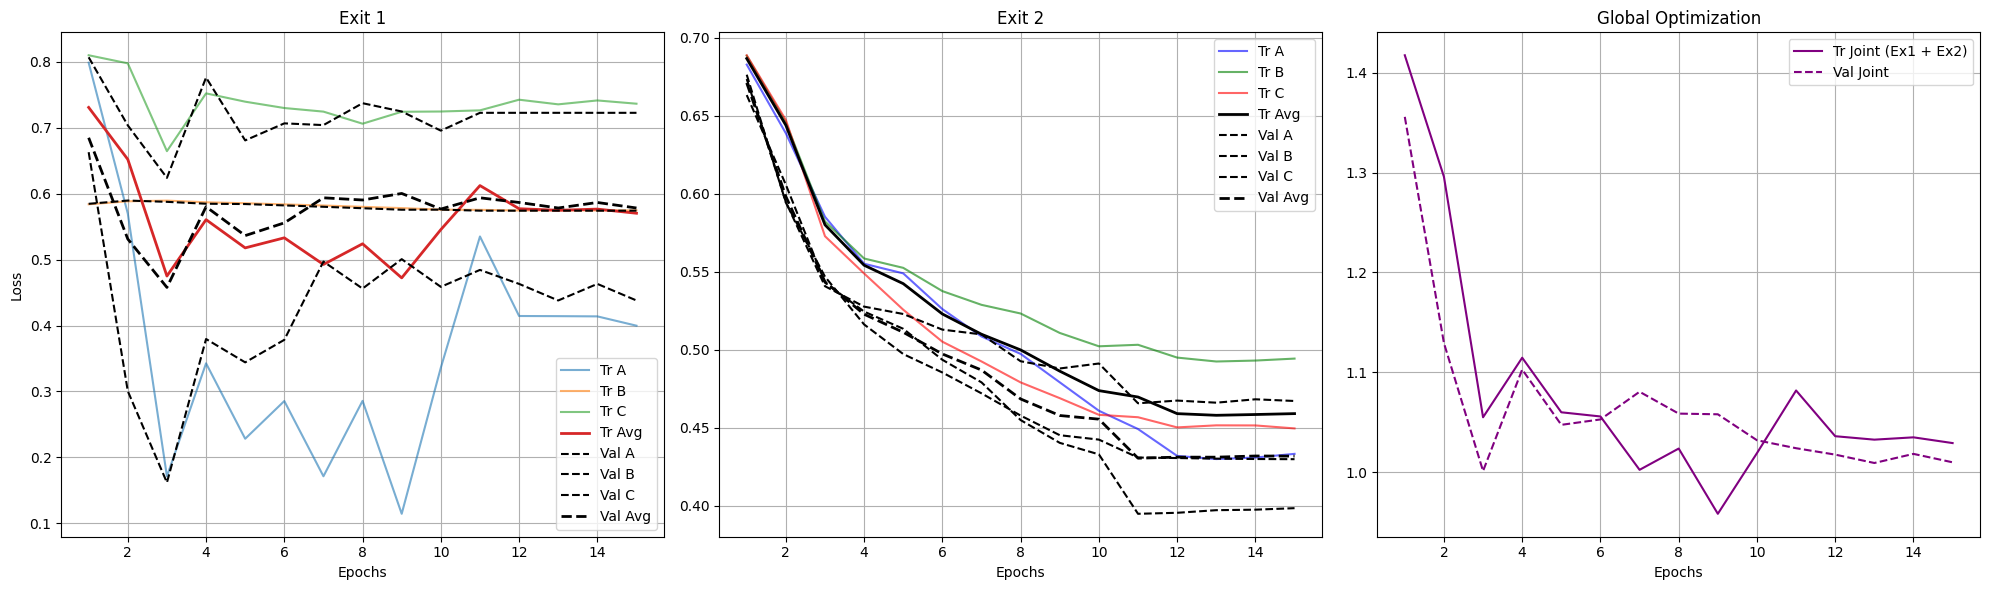


Modelo treinado e salvo em 'models/teste_ljoint9.pth'


In [23]:
epochs = 15

limiar = train_model(
    model, 
    train_loaders, 
    val_loaders, 
    epochs,
    current_threshold=0.55,
    lr=0.0001,
    device=device
)
torch.save(model.state_dict(), f'models/{modelname}.pth')
print(f"\nModelo treinado e salvo em 'models/{modelname}.pth'")

Modelo 'models/teste_ljoint9.pth' carregado

Base: UNSW


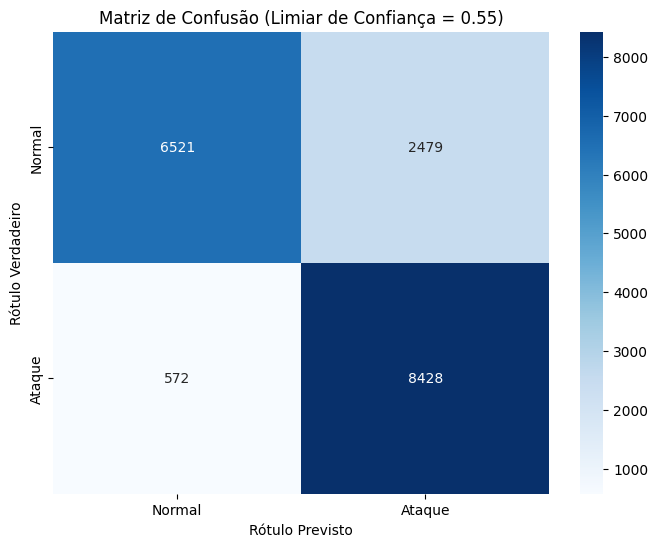

True Positives (TP): 8428
True Negatives (TN): 6521
False Positives (FP): 2479
False Negatives (FN): 572

F1 Score: 0.8467
True Positive Rate (TPR) / Recall: 0.9364
True Negative Rate (TNR) / Specificity: 0.7246
--------------------
  Accuracy: 83.0500%
  Avg. Inference Time: 0.0030 ms
  Early Exit Rate: 0.0667% (12/18000)
--------------------

Base: BOT


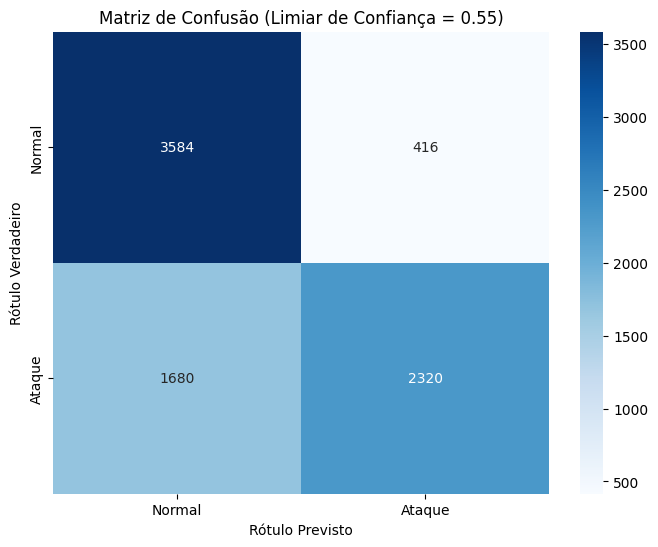

True Positives (TP): 2320
True Negatives (TN): 3584
False Positives (FP): 416
False Negatives (FN): 1680

F1 Score: 0.6888
True Positive Rate (TPR) / Recall: 0.5800
True Negative Rate (TNR) / Specificity: 0.8960
--------------------
  Accuracy: 73.8000%
  Avg. Inference Time: 0.0030 ms
  Early Exit Rate: 5.5250% (442/8000)
--------------------

Base: CIC


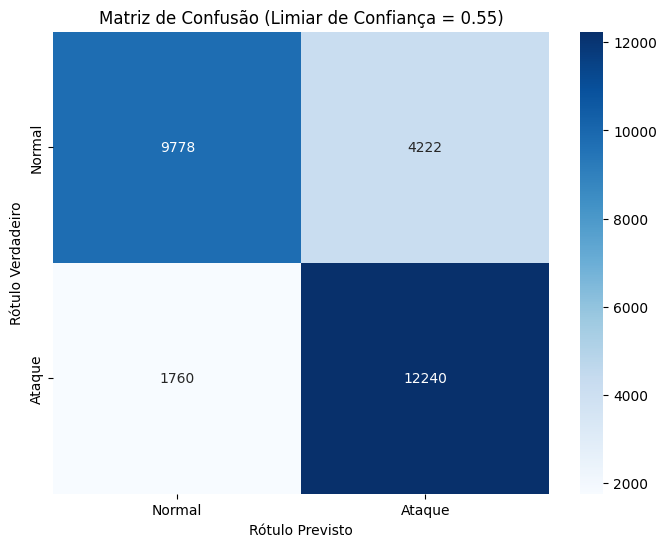

True Positives (TP): 12240
True Negatives (TN): 9778
False Positives (FP): 4222
False Negatives (FN): 1760

F1 Score: 0.8036
True Positive Rate (TPR) / Recall: 0.8743
True Negative Rate (TNR) / Specificity: 0.6984
--------------------
  Accuracy: 78.6357%
  Avg. Inference Time: 0.0030 ms
  Early Exit Rate: 0.6643% (186/28000)
--------------------


In [25]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
print(f"Modelo 'models/{modelname}.pth' carregado\n")

print(f"Base: UNSW")
results = evaluate_model(model, test_loaders[0], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)

print(f"\nBase: BOT")
results = evaluate_model(model, test_loaders[1], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)

print(f"\nBase: CIC")
results = evaluate_model(model, test_loaders[2], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)